In [ ]:
'''
Steps:

###### ensure point sources position and size ######
#### position
1. extract as many point sources using cheese as possible.
1.1 emlfill
2. comb merge the mos1, mos2, pn images,
3. blink check the missing point sources, add or sub the point sources ra,dec
#### size
3.1 create the new bkgregtdet/sky.fits using region commands
4. region and makemask command
# check the result if all the point sources size and radec are nice!

###### determine the cutoff flux or SB by logN-S #####
5. divide the region file into individual files
6. extract spectra from the region, make logN-logS plot
7. determine the excluded point sources cutoff flux

###### Final region mask #######
8. make new region file, last time check the position and the size
## crosscheck with eckert ##
9. edit the emllist.fits, *-bkgregtdet/sky.fits 
10. rerun the masks

'''

In [6]:
import os
import numpy as np
from glob import glob
from astropy.io import fits

In [17]:
# define homepath
# homepath = f'/Users/eusracenorth/Documents/work/XGAP-ABUN/data/RGH80/reduction'
# homepath = f'/Users/eusracenorth/Documents/work/XGAP-ABUN/data/ID9647/reduction'
homepath = f'/Users/eusracenorth/Documents/work/XGAP-ABUN/data/ID828/reduction'
# homepath = '/Users/eusracenorth/Documents/work/XGAP-ABUN/data/ID3460/reduction/SDSSTG3460'
os.chdir(f'{homepath}')

0 Exclude chips in the events
check set_chips_on.txt

In [227]:
exchip_dir = {'mos1S001':[3,4,6], 'mos2S002':[5], 'pnS003':[]}
express = f'''filtertype=expression imagebinning='imageSize' imagedatatype='Int32' squarepixels=yes ignorelegallimits=yes withxranges=yes withyranges=yes xcolumn='X' ximagesize=900 ximagemax=48400 ximagemin=3401 ycolumn='Y' yimagesize=900 yimagemax=48400 yimagemin=3401 updateexposure=yes filterexposure=yes verbosity=4'''

f = open('exchip_inevt.sh', 'w')

for name in ['mos1S001', 'mos2S002', 'pnS003']: # , 'mos2S002'
    add_express = ''
    input_evtfile = f'{name}-allevc.fits'
    output_evtfile = f'{name}-allevc-exchips.fits'
    output_imgfile = f'{name}-allevc-exchips_img.fits'
    if len(exchip_dir[name]) > 0:
        for chip in exchip_dir[name]:
            add_express += f'&&(CCDNR.ne.{chip})' 
        
    if 'mos' in name:
        f.write(f'''
evselect table={input_evtfile}:EVENTS withfilteredset=yes filteredset={output_evtfile} expression="(#XMMEA_EM)&&(PATTERN<=12)&&((FLAG & 0x766aa000) == 0){add_express}" {express} imageset={output_imgfile} \n''')
    else:
        f.write(f'''
evselect table={input_evtfile}:EVENTS withfilteredset=yes filteredset={output_evtfile} expression="(#XMMEA_EP)&&(PATTERN<=4)&&((FLAG & 0xb0000) == 0)&&((FLAG & 0x766aa000) == 0){add_express}" {express} imageset={output_imgfile} \n''')
        f.write(f'''
evselect table=pnS003-allevcoot.fits:EVENTS withfilteredset=yes filteredset=pnS003-allevcoot-exchips.fits expression="(#XMMEA_EP)&&(PATTERN<=4)&&((FLAG & 0xb0000) == 0)&&((FLAG & 0x766aa000) == 0){add_express}" {express} imageset={output_imgfile} \n''')

f.close()

1 extract as many point sources using cheese as possible


In [226]:
f = open('cheese.sh', 'w')
f.write(
'''
source set_sas.txt
elo=350 
ehi=2000
cheese mos1file='mos1S001-allevc-exchips.fits' mos2file='mos2S002-allevc-exchips.fits' pnfile='pnS003-allevc-exchips.fits' pnootfile='pnS003-allevcoot-exchips.fits' elowlist=$elo ehighlist=$ehi scale=0.5 mlmin=1 dist=1. ratetotal=3e-6 keepinterfiles=no 2>&1 | tee cheese_max.log
'''
)
f.close()

In [228]:
f = open('emlfill.sh', 'w')
f.write(f'emlfill emlin=emllist.fits emlout=emllist_filled.fits')
f.close()

2 comb merge the mos1, mos2, pn images,


In [230]:
f = open('comb_img.sh', 'w')

elo = 350
ehi = 2000

express = f'(PATTERN<=4)&&((FLAG & 0xb0000) == 0)&&((FLAG & 0x762a097c) == 0)&&(PI in [{elo}:{ehi}])&&(DETY in [-16510:14345])'
plot_express = f'''imagebinning='imageSize' imagedatatype='Int32' imageset=mos1S001-fovimt.fits squarepixels=yes ignorelegallimits=yes withxranges=yes withyranges=yes xcolumn='X' ximagesize=900 ximagemax=48400 ximagemin=3401 ycolumn='Y' yimagesize=900 yimagemax=48400 yimagemin=3401'''


f.write(f'''
source set_sas.txt
evselect table=pnS003-allevcoot-exchips.fits withimageset=Y {plot_express} expression='{express}' imageset='pnS003-fovimootsky-{elo}-{ehi}.fits'  \n''')
for name in ['mos1S001', 'mos2S002', 'pnS003']:
    f.write(f'mv {name}-fovimt.fits {name}-fovimsky-{elo}-{ehi}.fits\n')
    f.write(f'mv {name}-fovimtexp.fits {name}-expimsky-{elo}-{ehi}.fits\n')
f.write(f'''combimage prefixlist='1S001 2S002 S003' withcheese=yes cheesetype=t elowlist={elo} ehighlist={ehi} 2>&1 | tee combimg.log\n''')
f.write(f'''mv comb-fovimsky-{elo}-{ehi}.fits comb-fovimsky-{elo}-{ehi}_masked.fits\n''')
f.write(f'''mv comb-expimsky-{elo}-{ehi}.fits comb-expimsky-{elo}-{ehi}_masked.fits\n''')
f.write(f'''combimage prefixlist='1S001 2S002 S003' withcheese=no elowlist={elo} ehighlist={ehi} 2>&1 | tee -a combimg.log\n''')
f.close()

In [231]:
# convert the emllist.fits to region file with fixed circle of 15“
from astropy.io import fits

data_f = fits.open('emllist_filled.fits')
data = data_f[1].data

f = open('emllist_filled.reg', 'w')
f.write('''fk5\n''')

for i in range(len(data['ID_INST'])):
    if data[i]['ID_INST']==0:
        f.write(f'''circle({data[i]['RA']}, {data[i]['DEC']}, 15")\n''')
f.close()


3.0 Blink check the emllist_filled with the comb image!

3.1 create the new bkgregtdet/sky.fits using region commands

In [233]:
# create emllist_every.fits, include all the possible point sources
filename = f'emllist_filled.fits'
os.system(f'cp {filename} emllist_every.fits')

f = fits.open(filename)
dat = f[1].data
f.close()
dat['FLAG'] = 0

# load the styles of the recarray data 
sample_dype = dat.dtype
sample = dat[0]

# load the regions of complete pointsources
srcname = f'emllist_every.reg'
regfile = open(srcname)
lines = regfile.readlines()
regfile.close()

num = len(lines)-3
dat = dat[:num]

for i, f in enumerate(lines[3:]):
    ra = f.split('(')[-1].split(',')[0]
    dec = f.split(',')[1]
    dat[i]['RA'] = ra
    dat[i]['DEC'] = dec
    dat[i]['ML_ID_SRC'] = int(i+1)
    dat[i]['DIST_NN'] = 1000
    dat[i]['DET_ML'] = 20
    dat[i]['BOX_ID_SRC'] = int(i+1)
    dat[i]['ID_INST'] = 0
    dat[i]['ID_BAND'] = 0
    dat[i]['ID_CLUSTER'] = int(i+1)



newf = fits.open(f'emllist_every.fits', mode='update')
newf['SRCLIST'].data = dat
newf.flush()
newf.close()




4 1st run of region 

In [234]:
# ## if the SCTS is NULL in emllist_every.fits, the makemask won't work properly
# ## UPDATE: SCTS can't solve the problem!
f = fits.open('emllist_every.fits')
dat = f[1].data
for i in range(len(dat)):
    if ~np.isfinite(dat[i]['SCTS']):
        dat[i]['SCTS'] = 300

os.system('cp emllist_every.fits emllist_every_filled.fits')
newf = fits.open('emllist_every_filled.fits', mode='update')
newf[1].data = dat
newf.flush()


In [237]:
## edit region files
f = open(f'makemask_1st.sh', 'w')

f.write(
'''
source set_sas.txt
export M1=mos1S001
export M2=mos2S002
export PN=pnS003
export elo=350
export ehi=2000

mkdir cheese_old
for name in $M1 $M2 $PN
do
mv ${name}-cheeset.fits cheese_old
mv ${name}-bkgregtdet.fits cheese_old
mv ${name}-bkgregtsky.fits cheese_old

region eventset=${name}-allevc-exchips.fits srclisttab=emllist_every_filled.fits:SRCLIST operationstyle=batch energyfraction=0.5 radiusstyle=contour srcidcol=ML_ID_SRC shrinkconfused=no nosrcellipse=no nobkgellipse=no fovbkgannulus=no outunit=xy verbosity=4 regionset=sources_${name}_sky_srcreg.fits bkgregionset=sources_${name}_sky_bkgreg.fits | tee region-sky-${name}_2nd.log
region eventset=${name}-allevc-exchips.fits srclisttab=emllist_every_filled.fits:SRCLIST operationstyle=batch energyfraction=0.5 radiusstyle=contour srcidcol=ML_ID_SRC shrinkconfused=no nosrcellipse=no nobkgellipse=no fovbkgannulus=no outunit=detxy verbosity=4 regionset=sources_${name}_det_srcreg.fits bkgregionset=sources_${name}_det_bkgreg.fits | tee region-det-${name}_2nd.log

# makemask imagefile=${name}-fovimsky-$elo-$ehi.fits maskfile=${name}-fovimtmask.fits regionfile=${name}-bkgregtsky.fits cheesefile=${name}-cheeset.fits 2>&1 | tee makemask-${name}_1st.log
done

'''
)

f.close()

In [238]:
## convert the *bkgregtsky.fits to region file
# the physical coordinates in mos1S001,mos2S002,pnS003-bkgregtsky should be the same

f = open('sources_every_srcreg_phy.reg','w')
f.write('physical\n')

data_f = fits.open('sources_mos1S001_sky_srcreg.fits')

for i in range(1, len(data_f)):
    dat = data_f[i].data
    if np.isfinite(dat['R'][0][0]) & (dat['R'][0][0]>0):
        f.write(f'''ellipse({dat['X'][0][0]},{dat['Y'][0][0]},{dat['R'][0][0]},{dat['R'][0][1]},{dat['ROTANG'][0][0]})\n''')
    else:
        f.write(f'''ellipse({dat['X'][0][0]},{dat['Y'][0][0]},200,200,0)\n''')     

f.close()



In [239]:
## convert the *bkgregtsky.fits to region file
# the physical coordinates in mos1S001,mos2S002,pnS003-bkgregtsky should be the same

f = open('sources_every_bkgreg_phy.reg','w')
f.write('physical\n')

data_f = fits.open('sources_mos1S001_sky_bkgreg.fits')

for i in range(1,len(data_f)) :
    dat = data_f[i].data
    if len(dat) > 1:
        if np.isfinite(dat[0]['R'][0]) & (dat['R'][0][0]>0):
            f.write(f'''annulus({dat[0]['X'][0]},{dat[0]['Y'][0]},{dat[0]['R'][0]},{dat[0]['R'][1]})\n''')
        else:
            f.write(f'''annulus({dat[0]['X'][0]},{dat[0]['Y'][0]},600,600)\n''')     
        for j in range(1, len(dat)):
            if np.isfinite(dat[j]['R'][0]) & (dat['R'][0][0]>0):
                f.write(f'''-ellipse({dat[j]['X'][0]},{dat[j]['Y'][0]},{dat[j]['R'][0]},{dat[j]['R'][1]},{dat[j]['ROTANG'][0]})\n''')
            else:
                f.write(f'''-ellipse({dat[j]['X'][0]},{dat[j]['Y'][0]},250,250,0)\n''')
    else:
        f.write(f'''annulus({dat[0]['X'][0]},{dat[0]['Y'][0]},250,800)\n''')
        f.write(f'''-ellipse({dat[0]['X'][0]},{dat[0]['Y'][0]},250,250,0)\n''')
f.close()

5 check, resize some point sources regions, 
NOTE: and save to fk5 and physical coords 
(phy coords are the same for every inst)

In [240]:
# separate the edited regions to individual small region
## for srcreg
f = open('sources_every_srcreg_phy.reg')
lines = f.readlines()[1:]
f.close()

os.makedirs('srcs_regions', exist_ok=True)

for i, l in enumerate(lines):
    newf = open(f'srcs_regions/src_{int(i+1)}.reg', 'w')
    newf.write(f'&&((X,Y) IN {l.strip()})')
    newf.close()

In [241]:
## for bkgreg
f = open('sources_every_bkgreg_phy.reg')
lines = f.readlines()
f.close()

os.makedirs('srcs_regions', exist_ok=True)
i = 0

for l in enumerate(lines[1:]):
    if 'annu' in l[1]: 
        newf.close()
        i+=1
        newf = open(f'srcs_regions/bkg_{int(i)}.reg', 'w')
        newf.write(f'&&((X,Y) IN {l[1].strip()})')
    elif 'ellip' in l[1]:
        newf.write(f'&&!((X,Y) IN {l[1][1:].strip()})')

newf.close()
    

5.1 inspect sources_every_src/bkgreg_phy.reg!

6 extract spectra from source and bkg regions

In [242]:
sumf = open('sources_spec.sh', 'w')

for name in ['mos1S001', 'mos2S002', 'pnS003']:
    regdir = f'srcs_regions'
    regs = glob(f'{regdir}/src_*.reg')
    
    f = open(f'src_spec_{name}.sh', 'w')
    for reg in regs:

        sf = open(reg)
        regtxt = sf.readlines()[0]
        sf.close()

        if 'mos' in name:
            f.write(f'\n')
            f.write(f'evselect table={name}-allevc-exchips.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset={reg.split(".")[0]}_{name}_img.fits withspectrumset=Y spectrumset={reg.split(".")[0]}_{name}_spec.pi energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=11999 expression="(FLAG==0) && (PATTERN<=12) {regtxt}"  | tee {reg.split(".")[0]}_{name}_spec.log\n')
        else:
            f.write(f'\n')
            f.write(f'evselect table={name}-allevc-exchips.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset={reg.split(".")[0]}_{name}_img.fits withspectrumset=Y spectrumset={reg.split(".")[0]}_{name}_spec.pi energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression="(FLAG==0) && (PATTERN<=4) {regtxt}"  | tee {reg.split(".")[0]}_{name}_spec.log\n')
    f.close()
    sumf.write(f'''sh src_spec_{name}.sh\n''')
    

sumf.close()

In [243]:
sumf = open('sources_bkg_spec.sh', 'w')

for name in ['mos1S001', 'mos2S002', 'pnS003']:
    regdir = f'srcs_regions'
    regs = glob(f'{regdir}/bkg*.reg')
    
    f = open(f'bkg_spec_{name}.sh', 'w')
    for reg in regs:

        sf = open(reg)
        regtxt = sf.readlines()[0]
        sf.close()

        if 'mos' in name:
            f.write(f'\n')
            f.write(f'evselect table={name}-allevc-exchips.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset={reg.split(".")[0]}_{name}_img.fits withspectrumset=Y spectrumset={reg.split(".")[0]}_{name}_spec.pi energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=11999 expression="(FLAG==0) && (PATTERN<=12) {regtxt}"  | tee {reg.split(".")[0]}_{name}_spec.log\n')
        else:
            f.write(f'\n')
            f.write(f'evselect table={name}-allevc-exchips.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset={reg.split(".")[0]}_{name}_img.fits withspectrumset=Y spectrumset={reg.split(".")[0]}_{name}_spec.pi energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression="(FLAG==0) && (PATTERN<=4) {regtxt}"  | tee {reg.split(".")[0]}_{name}_spec.log\n')
    f.close()
    sumf.write(f'''sh bkg_spec_{name}.sh\n''')
    
sumf.close()

7 determine the cutoff flux

7.1 cal pointsource region area

In [ ]:
#### create separate region file in fk5
## 1. open sources_every_bkgreg_phy.reg	sources_every_srcreg_phy.reg in ds9 and convert phy to fk5
## 2. separate the sources*fk5.reg file to individual files 



In [245]:
os.chdir(f'{homepath}')
# separate the edited regions to individual small region
## for srcreg
f = open('sources_every_srcreg_fk5.reg')
lines = f.readlines()[3:]
f.close()

for i, l in enumerate(lines):
    newf = open(f'srcs_regions/fk5_src_{int(i+1)}.reg', 'w')
    newf.write(f'fk5\n')
    newf.write(f'{l.strip()}\n')
    newf.close()


In [246]:
## for bkgreg
f = open('sources_every_bkgreg_fk5.reg')
lines = f.readlines()
f.close()

i = 0

for l in enumerate(lines[3:]):
    if 'annu' in l[1]: 
        newf.close()
        i+=1
        newf = open(f'srcs_regions/fk5_bkg_{int(i)}.reg', 'w')
        newf.write(f'fk5\n')
        newf.write(f'{l[1].strip()}\n')
    elif 'ellip' in l[1]:
        newf.write(f'{l[1].strip()}\n')

newf.close()
    

In [248]:
#### create mask log
import pandas as pd

# f = open(f'{datapath}/cal_regionarea.sh', 'w')
CDELT = 6.94E-04 * 60 # arcmin per pixel
os.chdir(f'{homepath}/srcs_regions')

srcfiles = glob('fk5_src*reg')
num = len(srcfiles)
newf = open('cal_areaxsec.sh', 'w')

for name in ['mos1S001', 'mos2S002', 'pnS003']:

    for i in range(1,num+1):
        srcreg = f'fk5_src_{int(i)}.reg'
        bkgreg = f'fk5_bkg_{int(i)}.reg'

        # newf.write(f'rm {srcreg.split(".")[0]}_{name}_msk.fits\n')
        # newf.write(f'rm {bkgreg.split(".")[0]}_{name}_msk.fits\n')
        # newf.write(f'rm {srcreg.split(".")[0]}_{name}_msk_exp.fits\n')
        # newf.write(f'rm {bkgreg.split(".")[0]}_{name}_msk_exp.fits\n')
        # newf.write(f'rm {srcreg.split(".")[0]}_{name}_msk.log\n')
        # newf.write(f'rm {bkgreg.split(".")[0]}_{name}_msk.log\n')
        

        newf.write(f'ftimgcalc {srcreg.split(".")[0]}_{name}_msk.fits \'regfilter("{srcreg}",A.P1,A.P2) ? (1):(0)\' a=../{name}-expimsky-350-2000.fits clobber=yes\n')
        newf.write(f'ftimgcalc {bkgreg.split(".")[0]}_{name}_msk.fits \'regfilter("{bkgreg}",A.P1,A.P2) ? (1):(0)\' a=../{name}-expimsky-350-2000.fits clobber=yes\n')

        newf.write(f'farith {srcreg.split(".")[0]}_{name}_msk.fits ../{name}-expimsky-350-2000.fits {srcreg.split(".")[0]}_{name}_msk_exp.fits "*"\n')
        newf.write(f'farith {bkgreg.split(".")[0]}_{name}_msk.fits ../{name}-expimsky-350-2000.fits {bkgreg.split(".")[0]}_{name}_msk_exp.fits "*"\n')

        newf.write(f'fimgstat {srcreg.split(".")[0]}_{name}_msk_exp.fits threshlo=I threshup=I > {srcreg.split(".")[0]}_{name}_msk.log\n')
        newf.write(f'fimgstat {bkgreg.split(".")[0]}_{name}_msk_exp.fits threshlo=I threshup=I > {bkgreg.split(".")[0]}_{name}_msk.log\n')

newf.close()      


In [249]:
### make area csv ###

import pandas as pd

# f = open(f'{datapath}/cal_regionarea.sh', 'w')
CDELT = 2.5 # arcsec per pixel
# os.chdir('srcs_regions')

srcfiles = glob('fk5_src*reg')
num = len(srcfiles)
print(num)

for name in ['mos1S001', 'mos2S002', 'pnS003']:
    dir = {}
    dir['srcidx'] = np.arange(1,num+1)
    dir['srcarea[pixel]'] = np.zeros(int(num))
    dir['bkgarea[pixel]'] = np.zeros(int(num))

    for i in range(1,num+1):
        srcreg = f'fk5_src_{int(i)}.reg'
        bkgreg = f'fk5_bkg_{int(i)}.reg'
        
        f = open(f'{srcreg.split(".")[0]}_{name}_msk.log')
        lines = f.readlines()[:]
        f.close()
        for line in lines:
            if 'sum' in line:
                dir['srcarea[pixel]'][int(i-1)] = float(line.split('=')[-1])

        f = open(f'{bkgreg.split(".")[0]}_{name}_msk.log')
        lines = f.readlines()[:]
        f.close()
        for line in lines:
            if 'sum' in line:
                dir['bkgarea[pixel]'][int(i-1)] = float(line.split('=')[-1])

    df = pd.DataFrame(dir)
    df.to_csv(f'sources_areasxsec_{name}.csv', index=False)
        # backexp="{bkgtxt}"


66


In [187]:
### gen rmf ###
os.chdir(f'{homepath}/srcs_regions')

f = open(f'gen_rmf.sh', 'w')

specfiles = glob('src_1_*_spec.pi')

for specfile in specfiles:
    
    if 'mos1' in specfile:
        badpix_file = f'../mos1S001-fovimsky-350-8000.fits'
    elif 'mos2' in specfile:
        badpix_file = f'../mos2S002-fovimsky-350-8000.fits'
    else:
        badpix_file = f'../pnS003-fovimsky-350-8000.fits'

    f.write(f'''
rmfgen spectrumset={specfile} rmfset={specfile.split('.')[0]}.rmf detmaptype=flat extendedsource=yes badpixlocation={badpix_file}\n
        ''') 

f.close()


# arfgen spectrumset=source_{inst}_{obs}_bkg_spec_bin5.fits {set3} rmfset=source_{inst}_{obs}_bkg.rmf arfset=source_{inst}_{obs}_bkg.arf badpixlocation={inst}_hiband_loband_clean_fov.fits\n
#     for reg in ['oofov']:#['reg1', 'reg2', 'reg3', 'reg4', 'reg5']:
#         f.write(f'''
# rmfgen spectrumset=source_{inst}_{obs}_{reg}_spec_bin.fits rmfset=source_{inst}_{obs}_{reg}.rmf detmaptype=flat extendedsource=yes badpixlocation={inst}_hiband_loband_clean_fov.fits\n
#         ''')# arfgen spectrumset=source_{inst}_{obs}_{reg}_spec.fits {set3} rmfset=source_{inst}_{obs}_{reg}.rmf arfset=source_{inst}_{obs}_{reg}.arf badpixlocation={inst}_hiband_loband_clean_fov.fits\n

# f = open(f'gen_arf_rmf_{obs}.sh')
# print(f.readlines())

8 determine the excluded point sources cutoff flux

get counts rate from the spectrum

66
[894. 637. 487. 353.   0. 299.   0. 126.  82.  75.   0.   1.  28.  50.
  73.  50.   0.  66.  16. 144.  60.   0.   0.  89.  72.  74.  19.   0.
   0.  51.   0.   0.   0.   0.   0.  52.   0.   0.  35.  34.   0.   0.
  34.  30.  28.  44.  11.   9.   1.   0.  15.  27.   0.   0.  22.  16.
   0.  12.   0.   0.   0.  19.  22.   0.  15.  23.]
[866. 752. 538. 810.   0. 470.   0. 831. 435. 440.  53. 132. 175. 232.
 291. 229.   0. 332.  79. 286. 269.   0.   0. 278. 684. 556. 108.   0.
  45.  78.   0.   0.   0.   0.   0. 301.   0.  49. 156. 117.  93.  26.
 120. 183. 325. 212.  95. 116. 107.  78.  74.  54.   0.   0.  49. 134.
   0. 151.   0.   0.   0.  93. 152.   0.  52. 116.]
0     0.000055
1     0.000113
2     0.000046
3     0.000025
4          NaN
        ...   
61    0.000016
62    0.000018
63         NaN
64    0.000012
65    0.000028
Name: srcarea[pixel], Length: 66, dtype: float64
0     0.000008
1     0.000012
2     0.000007
3     0.000007
4          NaN
        ...   
61    0.000010
62    

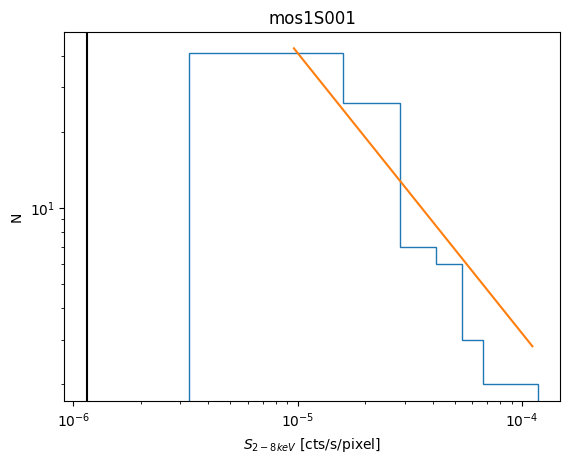

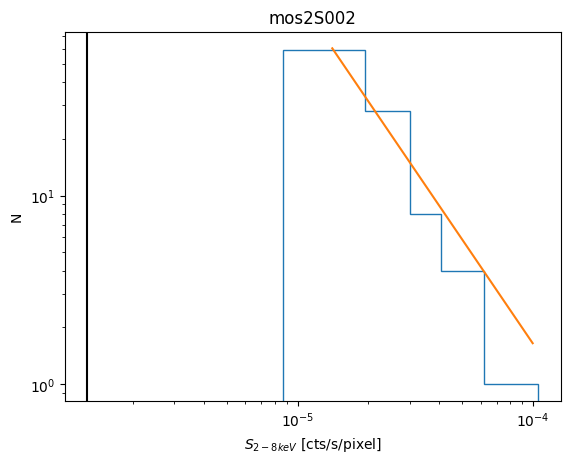

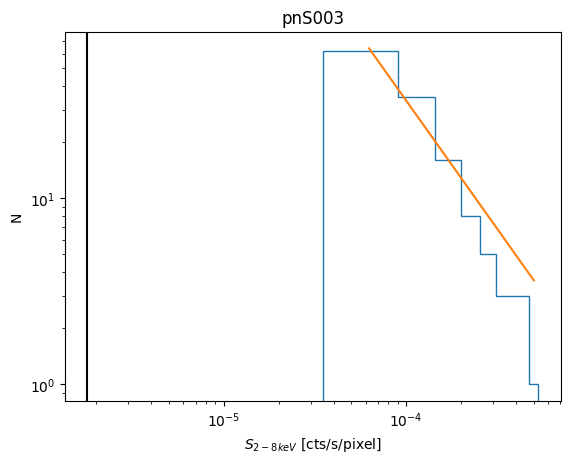

In [250]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


CDELT = 6.94E-04  # deg

regdir = f'{homepath}/srcs_regions'
os.chdir(regdir)

flux2cts = [4.907, 4.907, 13.55] # thin

sens = [1.15e-6, 1.28e-6, 1.78e-6]
xbreak_init = [4e-6, 3e-6, 7e-6]


srcspec_set = glob('src_*_*_spec.pi')
bkgspec_set = glob('bkg_*_*_spec.pi')
num = len(glob('src_*_mos1S001_spec.pi'))
print(num)



def broken_power_law(x, a1, a2, b2, x_break):
    b1=0
    y = np.piecewise(x, [x < x_break, x >= x_break], [lambda x: a1 * x ** b1, lambda x: a2 * x ** b2])
    return y

totctr_dict = {}
srcctr_dict = {}

for j, name in enumerate(['mos1S001', 'mos2S002', 'pnS003']):
    # read the s* arcmin2
    df = pd.read_csv(f'sources_areasxsec_{name}.csv')
    srcarea = df['srcarea[pixel]']
    bkgarea = df['bkgarea[pixel]']

    # # tranverse the channels to energies
    # rmf_file = glob(f'*_{name}_*.rmf')
    # f = fits.open(rmf_file[0])
    # ch2en = f[2].data
    # f.close()

    # elo = ch2en['E_MIN']
    # ehi = ch2en['E_MAX']
    # ch = ch2en['CHANNEL']
    # emsk = (elo < 8.0) & (elo >2.0)

    src_cts = np.zeros(int(num))
    bkg_cts = np.zeros(int(num))

    for i in range(1, num+1):
        srcspec = f'src_{i}_{name}_spec.pi'
        bkgspec = f'bkg_{i}_{name}_spec.pi'
        if (srcspec in srcspec_set) & (bkgspec in bkgspec_set):
            f = fits.open(f'{srcspec}')
            src_spec = f[1].data
            src_cts[int(i-1)] = np.sum(src_spec['COUNTS'])

            f = fits.open(f'{bkgspec}')
            bkg_spec = f[1].data
            bkg_cts[int(i-1)] = np.sum(bkg_spec['COUNTS'])
        else:
            src_cts[int(i-1)] = 0
            bkg_cts[int(i-1)] = 0

    print(src_cts)
    print(bkg_cts)
    srcctr = src_cts/(srcarea)
    srcctr[~np.isfinite(srcctr)] = np.nan

    bkgctr = bkg_cts/(bkgarea)
    bkgctr[~np.isfinite(bkgctr)] = np.nan
    print(srcctr)
    print(bkgctr)
####### make the plot #######
    
    fig = plt.subplots()
    plt.title(f'{name}')
    plt.xlabel(f'$S_{{2-8keV}}$ [cts/s/pixel]')
    plt.ylabel('N')

    plt.axvline(sens[j], c = 'k')
    
    totctr_dict[name] = srcctr-bkgctr
    srcctr_dict[name] = srcctr

    y, x = np.histogram(srcctr, bins = np.linspace(np.nanmin(srcctr), np.nanmax(srcctr), 10))

    hist_y = np.cumsum(y[::-1])[::-1]
    plt.stairs(hist_y, x)
    plt.yscale('log')
    plt.xscale('log')
    # plt.xlim(1e-3, 1)
    # plt.ylim(0,20)


    initial_guess = [1, 1, -0.1, xbreak_init[j]]  # a1, b1, a2, b2, x_break
    parameter_bounds = ([0, 0, -np.inf, 0], [np.inf, np.inf, 0, 5e-5])

    x_mid = x[0:-1] + np.diff(x)/2
    params, covariance = curve_fit(broken_power_law, x_mid[:-1], hist_y[:-1], p0=initial_guess, bounds=parameter_bounds)
    a1, a2, b2, x_break = params

    print(params)
    print(f'x_break_flux_to_mos = {x_break/flux2cts[j] * flux2cts[0]}')
    y_fit = broken_power_law(x_mid, a1, a2, b2, x_break)
    print(y_fit)
    plt.plot(x_mid, y_fit)
    # plt.hist(srcctr-bkgctr, bins = np.linspace(1e-7, 2e-5, 20))
    # plt.xlim(1e-7, 2e-5)

9 edit the emllist_final.fits
1) throw away the point sources under the cutoff limit 
cutoff limit is 3.0e-6 cts/s/pixel in mos, 7e-6 in pn
2) last adjust the size
3) check the result

9.1 throw away the point sources under the cutoff limit

   mos1S001  mos2S002    pnS003
0  0.000047  0.000045  0.000045
1  0.000101  0.000094  0.000122
2  0.000039  0.000024  0.000054
3  0.000018  0.000018  0.000035
4       NaN  0.000046  0.000071
5  0.000101  0.000004  0.000107
6       NaN  0.000027  0.000050
7  0.000010  0.000013  0.000017
8  0.000008  0.000007  0.000016


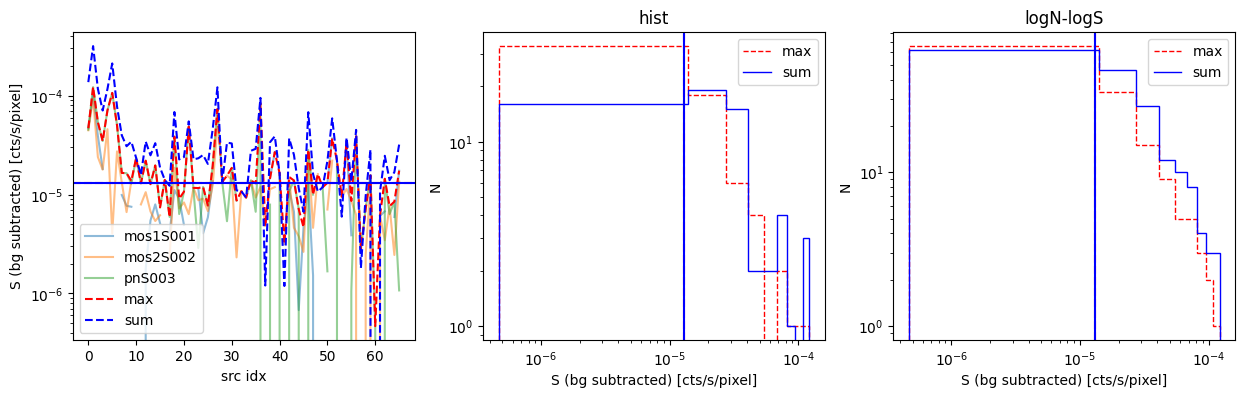

In [264]:
df = pd.DataFrame(totctr_dict)
# df[~np.isfinite(df)] = 0
df['pnS003'] = df['pnS003']/13.55 * 4.907
# ### not sub bkg:
# df = pd.DataFrame(srcctr_dict)
# df['pnS003'] = df['pnS003']/13.55 * 4.907

fig, axs = plt.subplots(1, 3, figsize=(15, 4)) 

for name in ['mos1S001', 'mos2S002', 'pnS003']: # 
    if 'pn' in name:
        axs[0].plot(np.arange(len(totctr_dict[name])), totctr_dict[name]/13.55 * 4.907, alpha = 0.5, label = name)
    else:
        axs[0].plot(np.arange(len(totctr_dict[name])), totctr_dict[name], alpha = 0.5, label = name)


v = np.nanmax(df, axis=1)
v1 = np.nansum(df, axis=1)
axs[0].plot(np.arange(len(totctr_dict[name])), v, 'r--', label = 'max')
axs[0].plot(np.arange(len(totctr_dict[name])), v1, 'b--', label = 'sum')

axs[0].legend()


print(df.iloc[0:9])
hist, bin = np.histogram(v, bins = np.linspace(np.nanmin(v), np.nanmax(v), 10))
axs[1].stairs(hist, bin, label = 'max', color ='r', linestyle = '--')
axs[2].stairs(np.cumsum(hist[::-1])[::-1], bin, label = 'max', color ='r', linestyle = '--')
hist, bin = np.histogram(v1, bins = np.linspace(np.nanmin(v), np.nanmax(v), 10))
axs[1].stairs(hist, bin, label = 'sum', color = 'b')
axs[2].stairs(np.cumsum(hist[::-1])[::-1], bin, label = 'sum', color ='b')

axs[1].legend()
axs[1].set_yscale('log')
axs[1].axvline(1.3e-5, c = 'r', linestyle = 'dashed')
axs[0].axhline(1.3e-5, c = 'r', linestyle = 'dashed')
axs[2].axvline(1.3e-5, c = 'r', linestyle = 'dashed')

axs[1].axvline(1.3e-5, c = 'b')
axs[0].axhline(1.3e-5, c = 'b')
axs[2].axvline(1.3e-5, c = 'b')

axs[1].set_title('hist')
axs[1].set_xscale('log')
axs[1].set_ylabel('N')
axs[1].set_xlabel('S (bg subtracted) [cts/s/pixel]')
axs[0].set_yscale('log')
axs[0].set_xlabel('src idx')
axs[0].set_ylabel('S (bg subtracted) [cts/s/pixel]')

axs[2].set_title('logN-logS')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_ylabel('N')
axs[2].set_xlabel('S (bg subtracted) [cts/s/pixel]')
axs[2].legend()

In [258]:
msk = v1>1.3e-5

print(f'''Every sources: {len(v)}''')
print(f'''Cut off point sources: {np.sum(~msk)}''')


sel_idx = list(np.arange(len(v))[msk])
os.chdir(homepath)

f = open(f'sources_every_srcreg_fk5.reg')
lines = f.readlines()[3:]
f.close()

newf = open(f'sources_final_sum_srcreg_fk5.reg', 'w')
newf.write('fk5\n')

for i in range(len(sel_idx)):
    newf.write(lines[sel_idx[i]])
newf.close()

Every sources: 66
Cut off point sources: 15


9.1 Last check the sum*final*reg! -> sum*final*edit.reg

10 2nd and last run of region command

if consider region command in cheese, 
this is actually the 3rd time to run region

In [18]:
# create emllist_final.fits, to convert the centers of fk5 coords to detxy and xy coords
filename = f'emllist_final.fits'
os.system(f'cp emllist.fits {filename}')

f = fits.open(filename)
dat = f[1].data
f.close()
dat['FLAG'] = 0

# load the styles of the recarray data 
sample_dype = dat.dtype
sample = dat[0]

# load the regions of complete pointsources
srcname = f'sources_final_sum_srcreg_fk5_edit.reg'
regfile = open(srcname)
lines = regfile.readlines()[:]
regfile.close()

num = len(lines)-3
dat = dat[:num]

for i, f in enumerate(lines[3:]):
    if len(f) > 1:
        ra = f.split('(')[-1].split(',')[0]
        dec = f.split(',')[1]
        dat[i]['RA'] = ra
        dat[i]['DEC'] = dec
        dat[i]['ML_ID_SRC'] = int(i+1)
        dat[i]['DIST_NN'] = 1000
        dat[i]['DET_ML'] = 20
        dat[i]['BOX_ID_SRC'] = int(i+1)
        dat[i]['ID_INST'] = 0
        dat[i]['ID_BAND'] = 0
        dat[i]['ID_CLUSTER'] = int(i+1)
    else:
        continue

newf = fits.open(f'{filename}', mode='update')
newf['SRCLIST'].data = dat
newf.flush()
newf.close()


In [19]:
## edit region files

os.makedirs('cheese_old', exist_ok=True)
f = open(f'region_2nd.sh', 'w')

f.write(
'''
source set_sas.txt
export M1=mos1S001
export M2=mos2S002
export PN=pnS003
export elo=350
export ehi=8000

for name in $M1 $M2 $PN
do

region eventset=${name}-allevc-exchips.fits operationstyle=global srclisttab=emllist_final.fits:SRCLIST expression="(ID_INST == 0)&&(DET_ML >= 1)" bkgregionset=${name}-bkgregtdet.fits energyfraction=0.4 radiusstyle=contour outunit=detxy verbosity=4 2>&1 | tee region-det-${name}_2nd.log
region eventset=${name}-allevc-exchips.fits operationstyle=global srclisttab=emllist_final.fits:SRCLIST expression="(ID_INST == 0)&&(DET_ML >= 1)" bkgregionset=${name}-bkgregtsky.fits energyfraction=0.4 radiusstyle=contour outunit=xy verbosity=4 2>&1 | tee region-sky-${name}_2nd.log

mv ${name}-bkgregtdet.fits ${name}-bkgregtdet_coords.fits
mv ${name}-bkgregtsky.fits ${name}-bkgregtsky_coords.fits

done

'''
)

f.close()

In [22]:
# alter the radius in *-bkgregtdet.fits and *-bkgregtsky.fits

as2det = 20 # 1arcsec to detxy or xy

for name in ['mos1S001', 'mos2S002', 'pnS003']:
    fname_det = f'{name}-bkgregtdet_coords.fits'
    fname_sky = f'{name}-bkgregtsky_coords.fits'
    
    for filename in [fname_det, fname_sky]:
        os.system(f'''cp {filename} {filename.split('_')[0]}.fits''')

        f = fits.open(filename)
        dat = f[1].data
        f.close()

        # load the styles of the recarray data 
        sample_dype = dat.dtype
        sample = dat[0]

        # load the regions of complete pointsources
        srcname = f'sources_final_sum_srcreg_fk5_edit.reg'
        regfile = open(srcname)
        lines = regfile.readlines()[:]
        regfile.close()

        num = len(lines)-3
        dat = dat[:num]

        for i, f in enumerate(lines[3:]):
            if len(f) > 1:
                if 'circle' in f:
                    r = float(f.split(',')[-1][:-3]) * as2det
                    dat[int(i)]['R'] = [r, r, 0, 0]
                elif 'ellipse' in f:
                    r2 = float(f.split(',')[-2][:-1]) * as2det
                    r1 = float(f.split(',')[-3][:-1]) * as2det
                    rot = float(f.split(',')[-1][:-2])
                    dat[int(i)]['R'] = [r1, r2, 0, 0]
                    dat[int(i)]['ROTANG'] = [rot, 0, 0, 0]

                else:
                    raise ValueError('Wrong shape, check the region file!')
            else:
                continue
        newf = fits.open(f'''{filename.split('_')[0]}.fits''', mode='update')
        newf['REGION'].data = dat
        newf.flush()
        newf.close()


In [23]:
## convert the *bkgregtsky.fits to region file
# the physical coordinates in mos1S001,mos2S002,pnS003-bkgregtsky should be the same

for name in ['mos1S001', 'mos2S002', 'pnS003']:
    data_f = fits.open(f'{name}-bkgregtsky.fits')
    dat = data_f[1].data

    f = open(f'{name}-bkgregtsky.reg','w')
    f.write('physical\n')
    for i in range(len(dat)):
        f.write(f'''ellipse({dat[i]['X'][0]},{dat[i]['Y'][0]},{dat[i]['R'][0]},{dat[i]['R'][1]},{dat[i]['ROTANG'][0]})\n''')
    f.close()



10.1 final check the regions! after that, make mask!

In [24]:
## make mask!
f = open(f'makemask_2nd.sh', 'w')
for name in ['mos1S001', 'mos2S002', 'pnS003']:
    f.write(f'''
makemask imagefile={name}-fovimsky-350-2000.fits maskfile={name}-fovimtmask.fits regionfile={name}-bkgregtsky.fits cheesefile={name}-cheeset.fits 2>&1 | tee makemask-{name}_2nd.log
    ''')

f.close()

10.2 check *-cheeset.fits!